In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from find_screen_utils import *
from __future__ import division
import warnings
from sklearn import linear_model

#*Image Processing*

##Contour Finding

In [35]:
img = cv2.imread('images/tobii/border/dropped/frame417.bmp')
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
thresh, bw_img = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

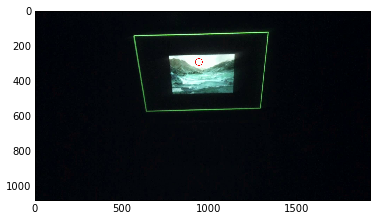

In [32]:
plt.imshow(img);

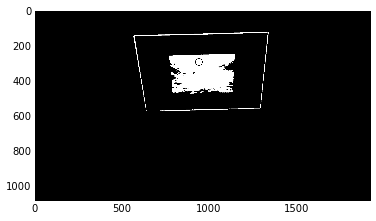

In [33]:
plt.imshow(bw_img, cmap='gray');

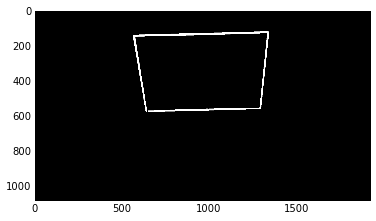

In [34]:
cont_img = np.zeros(bw_img.shape, dtype='uint8')
contours, hierarchy = cv2.findContours(bw_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
longest = np.argmax([cv2.arcLength(x, True) for x in contours])
cv2.drawContours(cont_img, contours, longest, 255, 5, 8, hierarchy, 0)
plt.imshow(cont_img, cmap='gray');

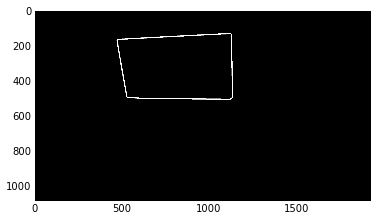

In [75]:
hull = cv2.convexHull(contours[longest])
hull = [hull]
hull_img = np.zeros(bw_img.shape, dtype='uint8')
cv2.drawContours(hull_img, hull, 0, 255, 5, 8)
plt.imshow(hull_img, cmap="gray");

## Edge Detection

In [36]:
edges = cv2.Canny(bw_img, threshold1=thresh, threshold2=thresh*1.5, apertureSize=3)

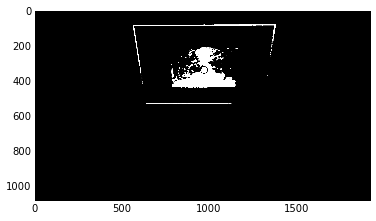

In [37]:
plt.imshow(bw_img, cmap='gray');

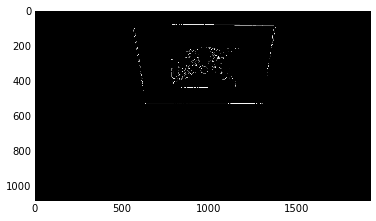

In [38]:
plt.imshow(edges, cmap='gray', clim=(0,255));

## Hough Lines

In [41]:
# Probabalistic (line segments)
line_img = np.array(img)
minLineLength = 100
maxLineGap = 15
lines = cv2.HoughLinesP(edges,1,np.pi/180,80, None, minLineLength,maxLineGap)
for x1,y1,x2,y2 in lines[0]:
    cv2.line(line_img,(x1,y1),(x2,y2),(255,0,0),10, lineType=4)

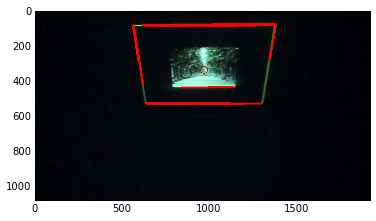

In [42]:
plt.imshow(line_img);

##Screen Extraction

In [43]:
plt_lines = get_lines(img, fit_edges(group_lines(lines[0])))

In [44]:
plt_img = np.array(img)
for x1,y1,x2,y2 in plt_lines:
    cv2.line(plt_img,(x1,y1),(x2,y2),(255,0,0),10, lineType=4)

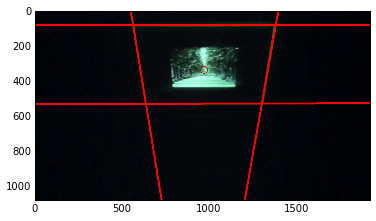

In [45]:
plt.imshow(plt_img);

In [46]:
corners = find_corners(img, plt_lines)

In [49]:
for corner in corners:
    cv2.circle(plt_img, corner, 25, [0,255,0], 10)

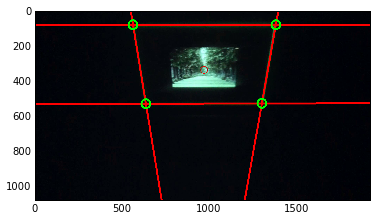

In [50]:
plt.imshow(plt_img);

In [51]:
corners = sort_corners(corners)
dest_corners = [(0,0), (1279,0), (1279,719), (0,719)]
trans = cv2.getPerspectiveTransform(np.array(corners).astype('float32'), np.array(dest_corners).astype('float32'))
trans_img = cv2.warpPerspective(img, trans, (1280,720))

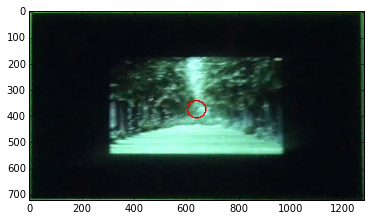

In [52]:
plt.imshow(trans_img);

## Dot Finding

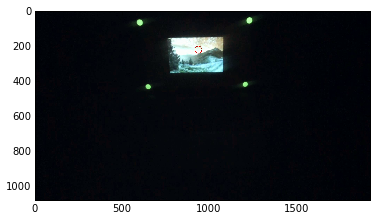

In [121]:
img = cv2.imread('images/tobii/border/frames/dark_dots/frame200.bmp')
plt.imshow(img);

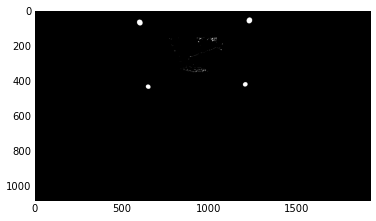

In [122]:
green_img = ((img[:,:,1]>200) & (img[:,:,0]<200) & (img[:,:,2]<200)).astype('uint8')
green_img[green_img == 1] = 255
green_img = cv2.GaussianBlur(green_img, (9, 9), 2, None, 2)
plt.imshow(green_img, cmap='gray');

In [123]:
circles = cv2.HoughCircles(green_img, cv2.cv.CV_HOUGH_GRADIENT, 1, 200, param1=100,
                           param2=1, minRadius=0, maxRadius=100)

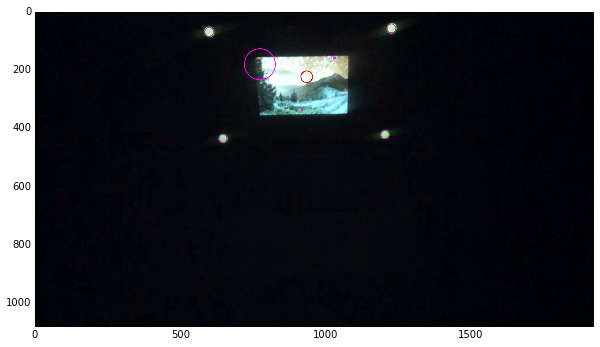

In [124]:
c_img = img.copy()
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(c_img,(i[0],i[1]),i[2],(255,0,255),2)
plt.figure(figsize=(10,10))
plt.imshow(c_img);

In [125]:
points = circles[0,:,0:2]
matches = find_corner_points(points)

In [126]:
dest = np.array(matches.keys()).astype('float32')
dest[:,0] = dest[:,0]*(1279./1919)
dest[:,1] = dest[:,1]*(719./1079)
src = np.array(matches.values())
trans = cv2.getPerspectiveTransform(src, dest)
trans_img = cv2.warpPerspective(img, trans, (1280,720))

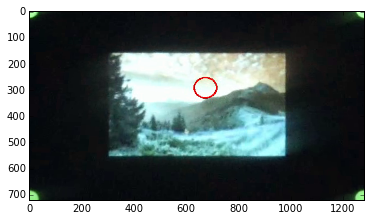

In [127]:
plt.imshow(trans_img);

##Line Finding

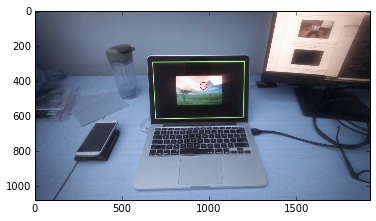

In [2]:
img = cv2.imread('images/tobii/border/dark_bg/frames/light_lines/frame1000.bmp')
# img = cv2.imread('images/tobii/border/gray_bg/dropped/frame1.bmp')
plt.imshow(img);

In [3]:
summed = img.sum(axis=2)
summed = np.dstack((summed, summed, summed))
warnings.filterwarnings("ignore")
norm = np.divide(img.astype('float32'), summed)
warnings.filterwarnings("default")

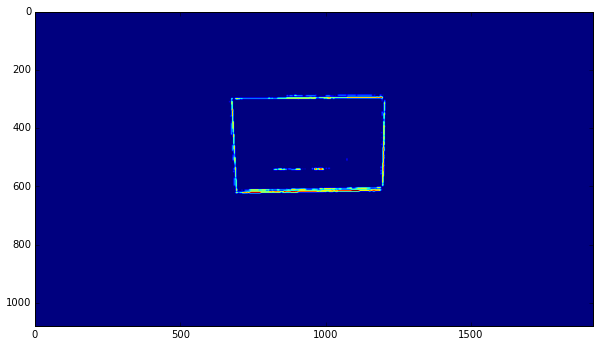

In [4]:
green_img = ((norm[:, :, 1] > 0.45)).astype('uint8')
green_img[green_img == 1] = 255
green_img = cv2.GaussianBlur(green_img, (9, 9), 2, None, 2)
plt.figure(figsize=(10,10))
plt.imshow(green_img);

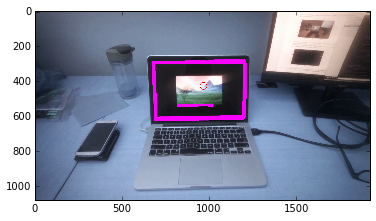

In [6]:
# Probabalistic (line segments)
line_img = img.copy()
minLineLength = 100
maxLineGap = 15
lines = cv2.HoughLinesP(green_img,1,np.pi/180,80, None, minLineLength,maxLineGap)
for x1,y1,x2,y2 in lines[0]:
    cv2.line(line_img,(x1,y1),(x2,y2),(255, 0, 255),10, lineType=4)
plt.imshow(line_img);

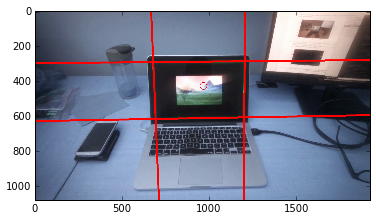

In [7]:
plt_lines = get_lines(img, fit_edges(group_lines(lines[0])))
# plt_lines = fit_robust_and_get_lines(img, group_lines(lines[0]))
plt_img = np.array(img)
for x1,y1,x2,y2 in plt_lines:
    cv2.line(plt_img,(x1,y1),(x2,y2),(255,0,0),10, lineType=4)
plt.imshow(plt_img);

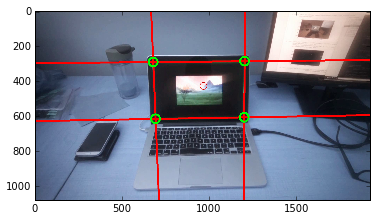

In [8]:
corners = find_corners(img, plt_lines)
corners = sort_corners(corners)
for corner in corners:
    cv2.circle(plt_img, corner, 25, [0,255,0], 10)
plt.imshow(plt_img);

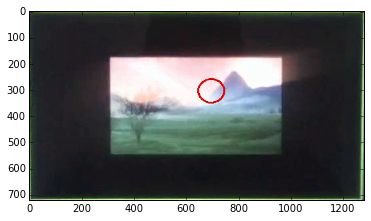

In [11]:
dest_corners = [(0,0), (1279,0), (1279,719), (0,719)]
trans = cv2.getPerspectiveTransform(np.array(corners).astype('float32'), np.array(dest_corners).astype('float32'))
trans_img = cv2.warpPerspective(img, trans, (1280,720))
plt.imshow(trans_img);

#*Video Processing*

##Frame Extraction Check

In [140]:
img = cv2.imread('images/tobii/border/dark_bg/frames/dark_lines/frame100.bmp')
proc_img = process_frame_lines(img, 'dark')

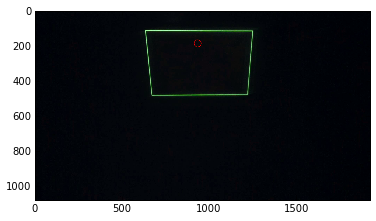

In [141]:
plt.imshow(img);

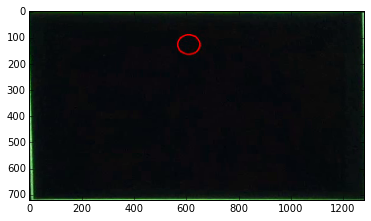

In [142]:
plt.imshow(proc_img);

##Process Video

In [4]:
vidnum = 2
infile = 'images/vid%i.mp4' % vidnum
outfile = 'images/vid%i_screen.m4v' % vidnum

In [5]:
vid = cv2.VideoCapture(infile)

size = (1280, 720)
fourcc = cv2.cv.CV_FOURCC(*'mp4v')
out = cv2.VideoWriter()
out.open(outfile, fourcc, vid.get(cv2.cv.CV_CAP_PROP_FPS), size, True)

last_good = np.zeros((720, 1280, 3), dtype=np.uint8)  # represents the last good frame

i = 1
while(vid.isOpened()):
    ret, frame = vid.read()
    if ret:
        proc_frame = process_frame(frame)
        
        if proc_frame == None:  # if screen isn't found, save image of frame
            cv2.imwrite('images/dropped/vid%i/frame%i.jpg'%(vidnum, i), frame)
            out.write(last_good)  # write the last good frame to the video
        else:  # frame is good
            # draw circles where the dot should turn (to measure accuary)
            cv2.circle(proc_frame, (320, 180), 36, [255,0,0], 2)
            cv2.circle(proc_frame, (960, 180), 36, [255,0,0], 2)
            cv2.circle(proc_frame, (960, 540), 36, [255,0,0], 2)
            cv2.circle(proc_frame, (320, 540), 36, [255,0,0], 2)
            
            last_good = proc_frame

            out.write(proc_frame)
        
        i += 1
    else:
        break


vid.release()
out.release()

/Users/shariqiqbal/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
